In [11]:
# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import jax.random as jr
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu
import matplotlib.pyplot as plt

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72


In [12]:
from dLuxToliman import AlphaCen

# Use the AlphaCen object for separation in units of arcseconds, and flux in log
source = AlphaCen()
source = source.set(['log_flux', 'separation'], [3.5, 0.1])

# Aperture properties
wf_npix = 128
diameter = 1

# Construct an aperture with a single spider as the asymmetry
coords = dlu.pixel_coords(5*wf_npix, diameter)
circle = dlu.circle(coords, diameter/2)
transmission = dlu.combine([circle], 5)

# Zernike aberrations
zernike_indexes = np.arange(4, 11)
true_coeffs = 1e-9 * jr.normal(jr.PRNGKey(0), zernike_indexes.shape)
coords = dlu.pixel_coords(wf_npix, diameter)
basis = np.array([dlu.zernike(i, coords, diameter) for i in zernike_indexes])

layers = [('aperture', dl.layers.BasisOptic(basis, transmission, true_coeffs, normalise=True))]

# Psf properties
psf_npixels = 16
psf_pixel_scale = 0.03

# Construct
optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npixels, psf_pixel_scale)

# Construct Telescope
telescope = dl.Telescope(optics, ('source', source))


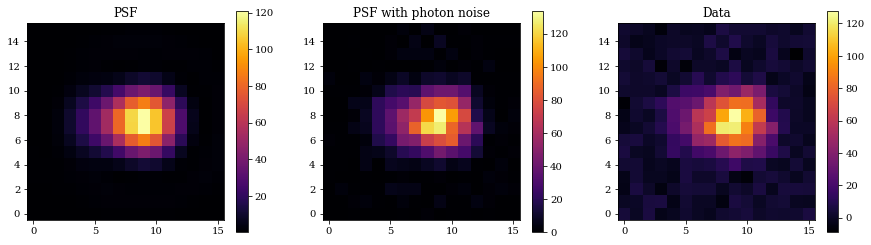

In [13]:
## Generate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()


In [14]:
# PPL
import numpyro as npy
import numpyro.distributions as dist

parameters = ['x_position', 'y_position', 'separation', 'position_angle', 
    'log_flux', 'contrast']

def psf_model(data, model):
    """
    Define the numpyro function
    """
    values = [
        npy.sample("x",        dist.Uniform(-0.1, 0.1)),
        npy.sample("y",        dist.Uniform(-0.1, 0.1)),
        npy.sample("r",        dist.Uniform(0.01, 0.5)),
        npy.sample("theta",    dist.Uniform(80, 100)),
        npy.sample("log_flux", dist.Uniform(3, 4)),
        npy.sample("contrast", dist.Uniform(1, 5)),
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())


ModuleNotFoundError: No module named 'numpyro'